In [1]:
from __future__ import division, print_function

import cPickle as pickle

import numpy as np
from scipy.spatial import cKDTree
from scipy import stats
from IPython import display
from IPython.html.widgets import interact

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import SkyCoord, Distance

from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy.table import Table

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import rcParams, animation
from mpl_toolkits.mplot3d import Axes3D

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [3]:
#previous round
#PiscA = SkyCoord('00h14m46s', '+10d48m47.01s', distance=Distance(distmod=np.array([24.59, 24.52, 24.68])+4))
#PiscB = SkyCoord('01h19m11.7s', '+11d7m18.22s', distance=Distance(distmod=np.array([25.96, 25.87, 26.07])+4))

In [3]:
#distances from MCMC
npz = np.load('PiscAB_distances.npz')
PiscA_dist = Distance(npz['piscA_dist_Mpc'], u.Mpc)
PiscB_dist = Distance(npz['piscB_dist_Mpc'], u.Mpc)

PiscA = SkyCoord('00h14m46s', '+10d48m47.01s', distance=Distance(np.percentile(PiscA_dist, [50, 10, 90]), u.Mpc))
PiscB = SkyCoord('01h19m11.7s', '+11d7m18.22s', distance=Distance(np.percentile(PiscB_dist, [50, 10, 90]), u.Mpc))

In [4]:
#structural parameters - need to define the SersicModel to be able to un-pickle
with open('chains_apr9_2015.pckl') as f:
    struc_param_dct = pickle.load(f)

def get_struc_param(chainnm, paramnm):
    sp = struc_param_dct['chains'+chainnm]
    idx = struc_param_dct['param_names'].index(paramnm)
    return sp[:, :, idx].ravel()

def minify_chains(*chains):
    chains = [np.array(chain, copy=False).ravel() for chain in chains]
    minchain = np.min([chain.size for chain in chains])
    return [chain[:minchain] for chain in chains]

In [5]:
m31 = SkyCoord(SkyCoord.from_name('M31'), distance=750*u.kpc)

In [6]:
#local void-ish direction
local_void_sc = SkyCoord('18h38m', '18d', distance=[0,20]*u.Mpc)

#Equatorial north/south direction
north_sc = SkyCoord(dec=90*u.deg,ra=0*u.deg,frame='icrs', distance=[0,20]*u.Mpc)
south_sc = SkyCoord(dec=-90*u.deg,ra=0*u.deg,frame='icrs', distance=[0,20]*u.Mpc)

In [7]:
ml = ascii.read('masterlist.csv')

In [8]:
msk = (ml['distance']>0)&(ml['distance']<15)
mml = ml[msk]
mlsc = SkyCoord(mml['RA']*u.deg, mml['Dec']*u.deg, distance=Distance(mml['distance'], u.Mpc))
mlcart = mlsc.cartesian
mlgcart = mlsc.galactic.cartesian
Kabsm = mml['K'] - mlsc.distance.distmod

In [9]:
twomasslimit = 13.5*u.mag-Distance(2**0.5*10*u.Mpc).distmod
mlgcomplmsk = Kabsm < twomasslimit.value
twomasslimit

<Quantity -17.252574989159953 mag>

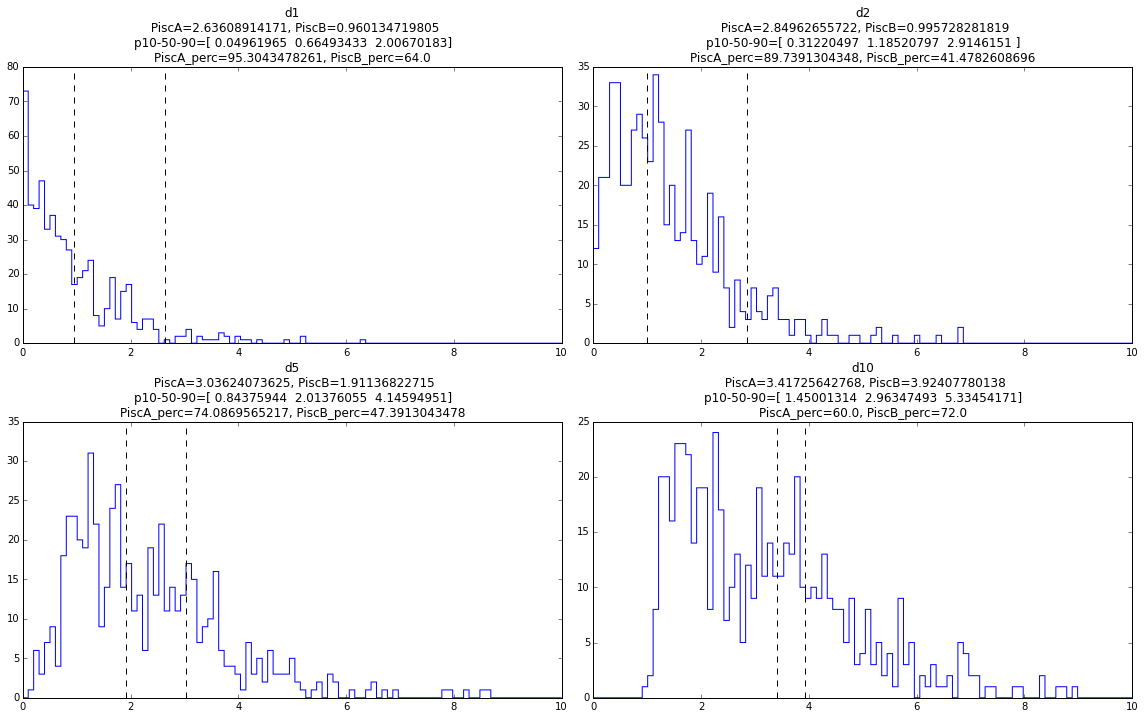

In [10]:
xyzall = np.concatenate((mlgcart.xyz.T[mlgcomplmsk], 
                         [PiscA.galactic.cartesian.xyz[:, 0], PiscB.galactic.cartesian.xyz[:, 0]]),
                        axis=0).value*u.Mpc

kdt = cKDTree(xyzall.value)
dkd, idx = kdt.query(kdt.data, 11)
d1 = dkd[:, 1]
d2 = dkd[:, 2] 
d5 = dkd[:, 5]
d10 = dkd[:, 10]

bins = np.linspace(0,10,100)
for i, di in enumerate('d1,d2,d5,d10'.split(',')):
    plt.subplot(2, 2, i+1)
    didat = locals()[di]
    plt.hist(didat, bins=bins, histtype='step')
    plt.axvline(didat[-1], c='k', ls='--')
    plt.axvline(didat[-2], c='k', ls='--')
    fmt = (np.percentile(didat, [10,50,90]), didat[-2], didat[-1], stats.percentileofscore(didat, didat[-2]), stats.percentileofscore(didat, didat[-1]))
    plt.title(di + '\n PiscA={1}, PiscB={2}\np10-50-90={0}\nPiscA_perc={3}, PiscB_perc={4}'.format(*fmt))
    print()
plt.tight_layout()

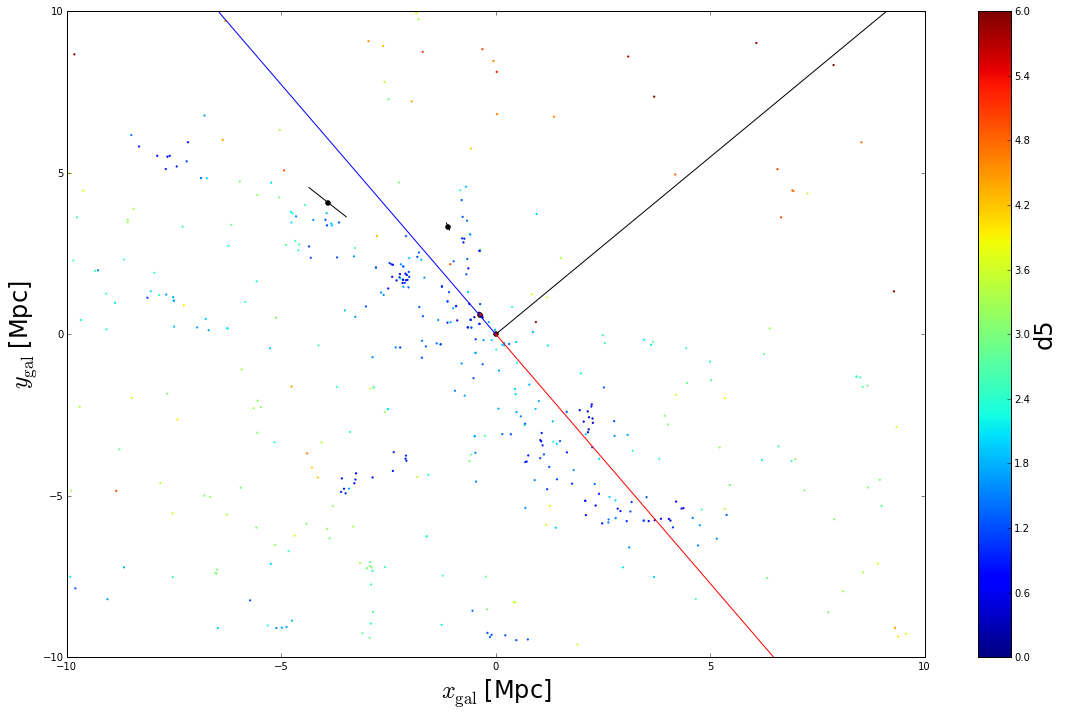

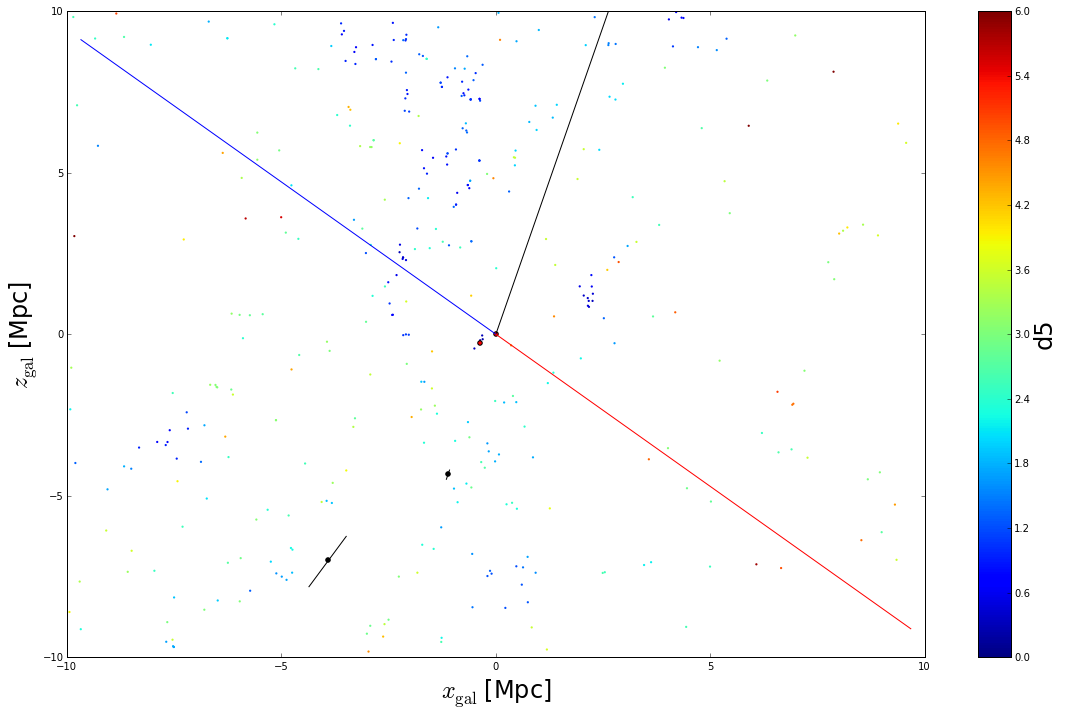

In [11]:
plt.figure(figsize=(16, 10))

colorarr, colorrng, colorlabel = Kabsm[mlgcomplmsk], [-23, twomasslimit.value], '$M_K$'
colorarr, colorrng, colorlabel = d5[:-2], [0,6], 'd5'

plt.scatter(mlgcart.x[mlgcomplmsk], mlgcart.y[mlgcomplmsk], edgecolor='none', 
            c=colorarr, s=5,vmin=colorrng[0], vmax=colorrng[1])
plt.colorbar().set_label(colorlabel, fontsize=24)
plt.scatter(PiscA.galactic.cartesian.x[:1], PiscA.galactic.cartesian.y[:1], color='k')
plt.plot(PiscA.galactic.cartesian.x[1:], PiscA.galactic.cartesian.y[1:], color='k')
plt.scatter(PiscB.galactic.cartesian.x[:1], PiscB.galactic.cartesian.y[:1], color='k')
plt.plot(PiscB.galactic.cartesian.x[1:], PiscB.galactic.cartesian.y[1:], color='k')
plt.scatter([m31.galactic.cartesian.x.to(u.Mpc).value, 0], [m31.galactic.cartesian.y.to(u.Mpc).value, 0],c='r')

plt.plot(local_void_sc.galactic.cartesian.x, local_void_sc.galactic.cartesian.y, color='k')
plt.plot(north_sc.galactic.cartesian.x, north_sc.galactic.cartesian.y, color='b')
plt.plot(south_sc.galactic.cartesian.x, south_sc.galactic.cartesian.y, color='r')

plt.xlabel(r'$x_{\rm gal}$ [Mpc]', fontsize=24)
plt.ylabel(r'$y_{\rm gal}$ [Mpc]', fontsize=24)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.tight_layout()

plt.figure(figsize=(16, 10))
plt.scatter(mlgcart.x[mlgcomplmsk], mlgcart.z[mlgcomplmsk], edgecolor='none', 
            c=colorarr, s=5, vmin=colorrng[0], vmax=colorrng[1])
plt.colorbar().set_label(colorlabel, fontsize=24)
plt.scatter(PiscA.galactic.cartesian.x[:1], PiscA.galactic.cartesian.z[:1], color='k')
plt.plot(PiscA.galactic.cartesian.x[1:], PiscA.galactic.cartesian.z[1:], color='k')
plt.scatter(PiscB.galactic.cartesian.x[:1], PiscB.galactic.cartesian.z[:1], color='k')
plt.plot(PiscB.galactic.cartesian.x[1:], PiscB.galactic.cartesian.z[1:], color='k')
plt.scatter([m31.galactic.cartesian.x.to(u.Mpc).value, 0], [m31.galactic.cartesian.z.to(u.Mpc).value, 0],c='r')

plt.plot(local_void_sc.galactic.cartesian.z, local_void_sc.galactic.cartesian.y, color='k')
plt.plot(north_sc.galactic.cartesian.x, north_sc.galactic.cartesian.z, color='b')
plt.plot(south_sc.galactic.cartesian.x, south_sc.galactic.cartesian.z, color='r')

plt.xlabel(r'$x_{\rm gal}$ [Mpc]', fontsize=24)
plt.ylabel(r'$z_{\rm gal}$ [Mpc]', fontsize=24)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.tight_layout()

In [10]:
#from Jeremy: color-code by correct gas fraction

# 3D plots

In [241]:
matplotlib.markers?

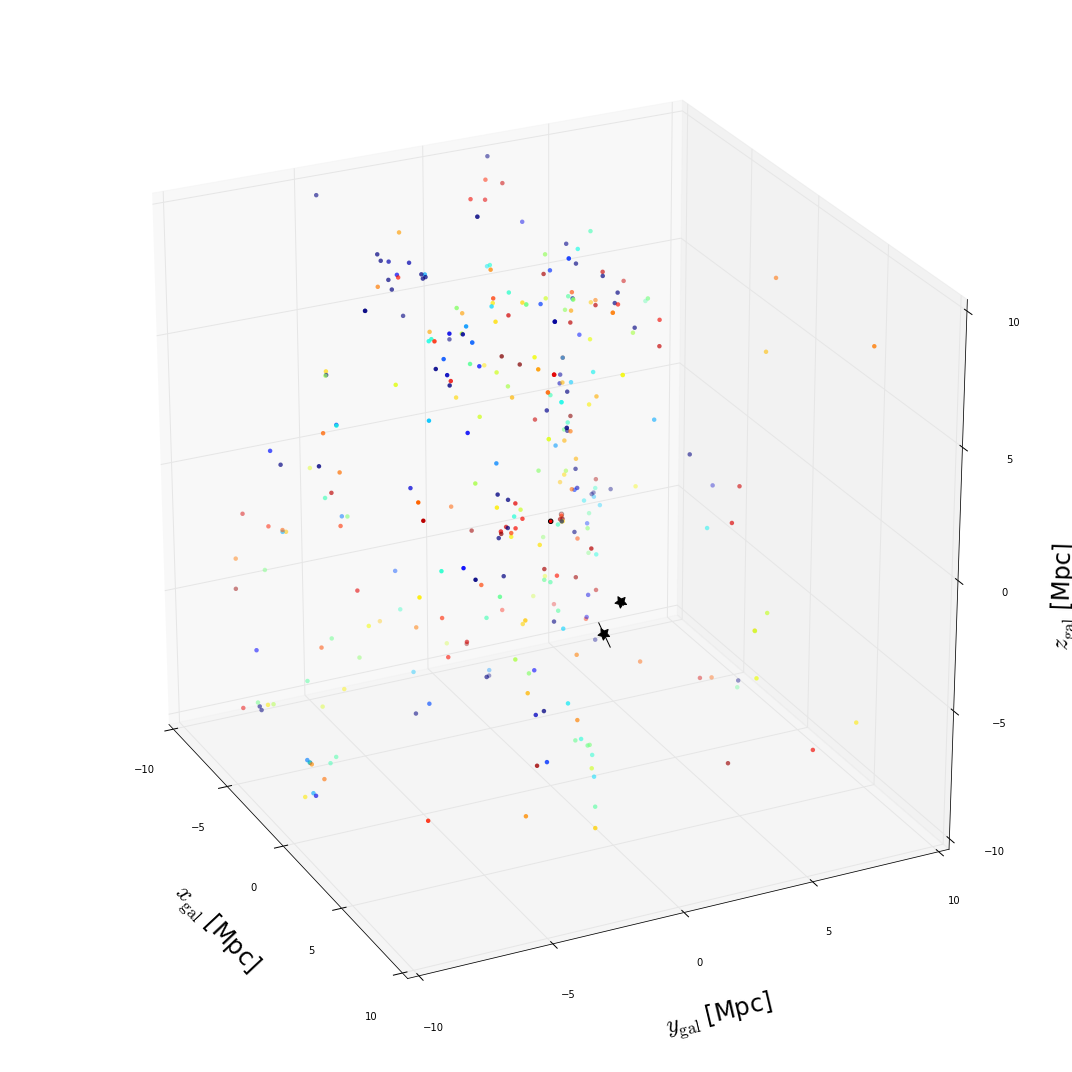

In [13]:
fig = plt.figure(figsize=(15,15))
fig.patch.set_alpha(1)
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(left=0,bottom=0,top=1,right=1, wspace=0, hspace=0)

msk10box = (-10<mlgcart.x.value)&(mlgcart.x.value<10)&(-10<mlgcart.y.value)&(mlgcart.y.value<10)&(-10<mlgcart.z.value)&(mlgcart.z.value<10)
lgscat = ax.scatter3D(mlgcart.x[msk10box&mlgcomplmsk], mlgcart.y[msk10box&mlgcomplmsk], mlgcart.z[msk10box&mlgcomplmsk], 
             edgecolor='none', c=Kabsm[msk10box&mlgcomplmsk], s=20,vmin=-23, vmax=twomasslimit.value)
#plt.colorbar().set_label('$M_K$', fontsize=24)
ax.scatter3D(PiscA.galactic.cartesian.x[:1], PiscA.galactic.cartesian.y[:1], PiscA.galactic.cartesian.z[:1], color='k', marker=(5, 1, 30), s=150)
ax.plot3D(PiscA.galactic.cartesian.x[1:], PiscA.galactic.cartesian.y[1:], PiscA.galactic.cartesian.z[1:], color='k')
ax.scatter3D(PiscB.galactic.cartesian.x[:1], PiscB.galactic.cartesian.y[:1], PiscB.galactic.cartesian.z[:1], color='k', marker=(5, 1, 30), s=150)
ax.plot3D(PiscB.galactic.cartesian.x[1:], PiscB.galactic.cartesian.y[1:], PiscB.galactic.cartesian.z[1:], color='k')
ax.scatter3D([m31.galactic.cartesian.x.to(u.Mpc).value, 0], [m31.galactic.cartesian.y.to(u.Mpc).value, 0],c='r')

#ax.plot3D(local_void_sc.galactic.cartesian.x, local_void_sc.galactic.cartesian.y, local_void_sc.galactic.cartesian.z, color='k')
#ax.plot3D(north_sc.galactic.cartesian.x, north_sc.galactic.cartesian.y, north_sc.galactic.cartesian.z, color='b')
#ax.plot3D(south_sc.galactic.cartesian.x, south_sc.galactic.cartesian.y, south_sc.galactic.cartesian.z, color='r')

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel(r'$x_{\rm gal}$ [Mpc]', fontsize=24)
ax.set_ylabel(r'$y_{\rm gal}$ [Mpc]', fontsize=24)
ax.set_zlabel(r'$z_{\rm gal}$ [Mpc]', fontsize=24)
#cb=plt.colorbar(lgscat)
#cb.set_label('$M_K$',fontsize=28)
#cb.ax.tick_params(labelsize=20) 
plt.tight_layout()
plt.savefig('test.png')

@interact(azim=(-180, 180., 1.0), elev=(-90., 90., 1.0))
def f(azim=0, elev=0):
    ax.azim = azim
    ax.elev = elev
    display.display(fig)

In [260]:
#use this to save the above as a movie

totframes = 600
frames_per_segment = totframes/4

def animate(i):
    if i < frames_per_segment:
        j = i
        ax.azim = 180*j/frames_per_segment
        ax.elev = 0
    elif i < frames_per_segment*2:
        j = i - frames_per_segment
        ax.azim = 180
        ax.elev = 60*j/frames_per_segment
    elif i < frames_per_segment*3:
        j = i - frames_per_segment*2
        ax.azim = 180*j/frames_per_segment + 180
        ax.elev = 60
    else:
        j = i - frames_per_segment*3
        ax.azim = 360 - .1
        ax.elev = 60-60*j/frames_per_segment
        
    print(i/totframes, end='\r')

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=totframes, interval=20)
anim.save('test.mp4', bitrate=10000)

# R/MV plot

## Other data sets

In [111]:
import nearbygals

ngtab = nearbygals.get_table('/Users/erik/astrodata/mcconn12_nearbydwarfs/NearbyGalaxies.dat', dropmw=False)

mw = SkyCoord(l=0*u.deg,b=0*u.deg, distance=8.5*u.kpc, frame='galactic').icrs
m31 = ngtab[ngtab['name']=='Andromeda']['center'][0]

m31d = np.array([m31.separation_3d(c).kpc for c in ngtab['center']])
mwd = np.array([mw.separation_3d(c).kpc for c in ngtab['center']])
mwd[0] = 0 #The MW itself
m31closer = m31d < mwd

ds = ngtab['distance'].copy()
vhs = ngtab['vh']
vabs = ngtab['Vabs']
ds[m31closer] = m31d[m31closer]
ds[~m31closer] = mwd[~m31closer]

In [112]:
sfingdct = {'And XXX': False,
 'And XXXI': False,
 'And XXXII': False,
 'Andromeda': True,
 'Andromeda I': False,
 'Andromeda II': False,
 'Andromeda III': False,
 'Andromeda IX': False,
 'Andromeda V': False,
 'Andromeda VI': False,
 'Andromeda VII': False,
 'Andromeda X': False,
 'Andromeda XI': False,
 'Andromeda XII': False,
 'Andromeda XIII': False,
 'Andromeda XIV': False,
 'Andromeda XIX': False,
 'Andromeda XV': False,
 'Andromeda XVI': False,
 'Andromeda XVII': False,
 'Andromeda XVIII': False,
 'Andromeda XX': False,
 'Andromeda XXI': False,
 'Andromeda XXII': False,
 'Andromeda XXIII': False,
 'Andromeda XXIV': False,
 'Andromeda XXIX': False,
 'Andromeda XXV': False,
 'Andromeda XXVI': False,
 'Andromeda XXVII': False,
 'Andromeda XXVIII': False,
 'Antlia': True,
 'Aquarius': True,
 'Bootes (I)': False,
 'Bootes II': False,
 'Bootes III': False,
 'Canes Venatici (I)': False,
 'Canes Venatici II': False,
 'Canis Major': False,
 'Carina': False,
 'Cetus': False,
 'Coma Berenices': False,
 'DDO 113': True,
 'DDO 125': True,
 'DDO 190': True,
 'DDO 99': True,
 'Draco': False,
 'ESO 294- G 010': False,
 'ESO 410- G 005': False,
 'Fornax': False,
 'GR 8': True,
 'HIZSS 3(A)': True,
 'HIZSS 3B': True,
 'Hercules': False,
 'IC 10': True,
 'IC 1613': True,
 'IC 3104': True,
 'IC 4662': True,
 'IC 5152': True,
 'KKH 86': True,
 'KKH 98': True,
 'KKR 25': False,
 'KKR 3': True,
 'LGS 3': True,
 'LMC': True,
 'Leo A': True,
 'Leo I': False,
 'Leo II': False,
 'Leo IV': False,
 'Leo P': True,
 'Leo T': True,
 'Leo V': False,
 'M32': False,
 'NGC 147': False,
 'NGC 185': False,
 'NGC 205': False,
 'NGC 300': True,
 'NGC 3109': True,
 'NGC 4163': True,
 'NGC 55': True,
 'NGC 6822': True,
 'Pegasus dIrr': True,
 'Phoenix': True,
 'Pisces II': False,
 'SMC': True,
 'Sagittarius dIrr': True,
 'Sagittarius dSph': False,
 'Sculptor': False,
 'Segue (I)': False,
 'Segue II': False,
 'Sextans (I)': False,
 'Sextans A': True,
 'Sextans B': True,
 'The Galaxy': True,
 'Triangulum': True,
 'Tucana': False,
 'UGC 4879': True,
 'UGC 8508': True,
 'UGC 9128': True,
 'UGCA 86': True,
 'UKS 2323-326': True,
 'Ursa Major (I)': False,
 'Ursa Major II': False,
 'Ursa Minor': False,
 'WLM': True,
 'Willman 1': False}
sfing = np.array([sfingdct[nm] for nm in ngtab['name']])

In [113]:
leopmstar=5.7e5 * u.solMass
leopmhi=9.3e5 * u.solMass
leopdist=1.72*u.Mpc
leopMV=-9.41*u.mag
leopRelim=0.58*u.kpc  #that's the "Semimajor axis", which isn't really Re
leopRe=.188*u.kpc #from below

In [114]:
mw = SkyCoord(l=0*u.deg,b=0*u.deg, distance=8.5*u.kpc, frame='galactic').icrs
m31 = ngtab[ngtab['name']=='Andromeda']['center'][0]

m31d = np.array([m31.separation_3d(c).kpc for c in ngtab['center']])
mwd = np.array([mw.separation_3d(c).kpc for c in ngtab['center']])
mwd[0] = 0 #The MW itself
m31closer = m31d < mwd

ds = ngtab['distance'].copy()
vhs = ngtab['vh']
vabs = ngtab['Vabs']
ds[m31closer] = m31d[m31closer]
ds[~m31closer] = mwd[~m31closer]

Rh = u.Quantity(ngtab['rh'], u.arcmin)
dlos = u.Quantity(ngtab['distance'])
Reff = Rh.to(u.radian).value*dlos

mag2lmstar = lambda mag, mag_sun=4.65, mtol=1: (mag - mag_sun)/-2.5 + np.log10(mtol)

mhing = u.Quantity(ngtab['MHI'], u.solMass)
lmhing = np.log10(mhing/u.solMass).value

lMstarng = np.array(mag2lmstar(ngtab['Vmag'] - ngtab['distmod'], 4.83, 1))

In [115]:
#from Cannon+ 11
shieldtabstr="""
Table 1
VLA/EVLA Observations of ALFALFA-selected Low-mass Dwarf Galaxies

AGC^a	alpha	delta	Distance	M_r	(u - r)	M_B	(B - V)	%Z_sun^b	V_21	W_21	log (M_H i)	
	(J2000)	(J2000)	(Mpc)	(mag)	(mag)	(mag)	(mag)		(km s^-1)	(km s^-1)	(M_sun)	
Concept demonstration targets	
100062	00:09:52.8	15:43:58	12.7^c	-15.02	1.02 +or- 0.02	N/A	N/A	N/A	869	45	7.82	
101772	00:11:08.2	14:14:08	11.7^c	-13.64	0.98 +or- 0.06	N/A	N/A	N/A	802	37	7.54	
111945	01:44:42.7	27:17:18	6.3^c	-11.88^d	3.35 +or- 1.26^d	N/A	N/A	N/A	420	38	7.28	
321203	22:13:03.3	28:04:28	16.4^c	-14.20	0.98 +or- 0.04	N/A	N/A	14%	983	62	7.83	
321307	22:14:04.4	25:41:08	18.7^c	-13.88	1.24 +or- 0.07	N/A	N/A	N/A	1152	60	7.96	
332939	23:08:16.0	31:53:57	11.4^c	-13.67	0.69 +or- 0.05	N/A	N/A	N/A	692	41	7.74	
	
The SHIELD sample	
748778^e	00:06:34.3	15:30:39	5.4^c	-10.52	0.81 +or- 0.19	-10.02	0.25 +or- 0.03	N/A	258	16	6.51	
112521^e	01:41:07.6	27:19:24	7.2^f	-11.52^d	2.19 +or- 0.42^d	-10.80	0.45 +or- 0.03	6%	274	26	6.92	
110482^e	01:42:17.4	26:22:00	7.2^f	-13.63	1.25 +or- 0.04	-12.86	0.49 +or- 0.02	13%	357	30	7.21	
111946^e	01:46:42.2	26:48:05	7.2^f	-11.49^d	1.46 +or- 0.25^d	-11.48	0.39 +or- 0.03	5%	367	21	6.97	
111977^e	01:55:20.2	27:57:14	5.5^g	-12.55^d	2.26 +or- 0.16^d	-12.31	0.47 +or- 0.02	N/A	207	26	6.78	
111164^e	02:00:10.1	28:49:52	4.9^g	-11.50^d	0.80 +or- 0.09^d	-11.10	0.41 +or- 0.02	N/A	163	27	6.57	
174585^h,^i	07:36:10.3	09:59:11	6.1^c	N/A	N/A	N/A	N/A	N/A	356	21	6.68	
174605^h	07:50:21.7	07:47:40	6.0^c	-10.46^d	1.85 +or- 0.21^d	-10.98	0.47 +or- 0.05	N/A	351	24	6.75	
182595^h	08:51:12.1	27:52:48	6.1^c	-12.45	1.27 +or- 0.05	-11.75	0.52 +or- 0.05	N/A	398	20	6.66	
731457^h	10:31:55.8	28:01:33	5.4^c	-12.55	1.23 +or- 0.03	-12.02	0.39 +or- 0.05	N/A	454	36	6.63	
749237^h	12:26:23.4	27:44:44	3.2^c	-11.58	1.28 +or- 0.03	-11.21	0.44 +or- 0.05	N/A	372	65	6.64	
749241^h	12:40:01.7	26:19:19	4.3^c	-9.27	0.83 +or- 0.15	-9.57	0.22 +or- 0.05	N/A	451	18	6.52	

Notes.
a Arecibo General Catalog.
b Assuming the solar oxygen abundance from Asplund et al. (2009).
c Derived using the parametric multiattractor flow model developed by Masters (2005); see further discussion in Martin et al. (2010).
d Magnitudes and colors uncertain due to SDSS shredding issues.
e WIYN 3.5 m imaging acquired in Fall 2010.
f Probable member of NGC 672 group.
g Tip of the red giant branch.
h WIYN 3.5 m imaging acquired in Spring 2011.
i AGC 174585 is outside the SDSS footprint; an absolute calibration of the WIYN 3.5 m observations awaits subsequent re-imaging.
"""[1:-1]

indat = False
shinum = []
shiMr = []
shilMHI = []
shiw50 = []
for ln in shieldtabstr.split('\n'):
    if ln.startswith('Concept demonstration targets') or ln.startswith('The SHIELD sample'):
        indat = True
    elif indat:
        if ln.strip() == '':
            indat = False
        else:
            lns = ln.strip().split('\t')
            if lns[4] != 'N/A':
                shinum.append(int(lns[0].split('^')[0]))
                shiMr.append(float(lns[4].split('^')[0]))
                shilMHI.append(float(lns[-1]))
                shiw50.append(float(lns[-2]))

shinum = np.array(shinum)
shiMr = np.array(shiMr)
shilMHI = np.array(shilMHI)
shiw50 = np.array(shiw50)     
shilMstar = mag2lmstar(shiMr)

In [196]:
#same for 2014-11-08 and 2014-10-30
zeroptinfo="""
FILTER  	  PHOTPLAM  	  PHOTFLAM  	  STmag  	  VEGAmag 	  ABmag

F606W
5921.8
7.844e-20
26.664
26.407
26.493

F814W
8059.3
7.007e-20
26.786
25.523
25.947
"""
f606wzpt = 26.407*u.mag
f814wzpt = 25.523*u.mag

In [213]:
PiscB_606 = f606wzpt-2.5*np.log10(get_struc_param('606B', 'flux'))*u.mag
PiscA_606 = f606wzpt-2.5*np.log10(get_struc_param('606A', 'flux'))*u.mag
PiscB_814 = f814wzpt-2.5*np.log10(get_struc_param('814B', 'flux'))*u.mag
PiscA_814 = f814wzpt-2.5*np.log10(get_struc_param('814A', 'flux'))*u.mag

minchains = min(PiscA_606.size, PiscA_dist.ravel().size)
PiscA_M606 = PiscA_606[:minchains] - PiscA_dist.distmod.ravel()[:minchains]
minchains = min(PiscB_606.size, PiscB_dist.ravel().size)
PiscB_M606 = PiscB_606[:minchains] - PiscB_dist.distmod.ravel()[:minchains]

M606s = u.Quantity([np.median(PiscA_M606), np.median(PiscB_M606)])

In [218]:
wfc_platescale = 0.05*u.arcsec
PiscA_reff_sky = get_struc_param('606A', 'reffmaj')*get_struc_param('606A', 'ellipticity')**0.5*wfc_platescale
PiscB_reff_sky = get_struc_param('606B', 'reffmaj')*get_struc_param('606B', 'ellipticity')**0.5*wfc_platescale

minchains = min(PiscA_reff_sky.size, PiscA_dist.ravel().size)
PiscA_reff = PiscA_reff_sky[:minchains].to(u.radian).value*PiscA_dist.ravel()[:minchains]
minchains = min(PiscB_reff_sky.size, PiscB_dist.ravel().size)
PiscB_reff = PiscB_reff_sky[:minchains].to(u.radian).value*PiscB_dist.ravel()[:minchains]

Pisc_reffs = u.Quantity([np.median(PiscA_reff), np.median(PiscB_reff)])

[-9.41] [ 2.27415785]


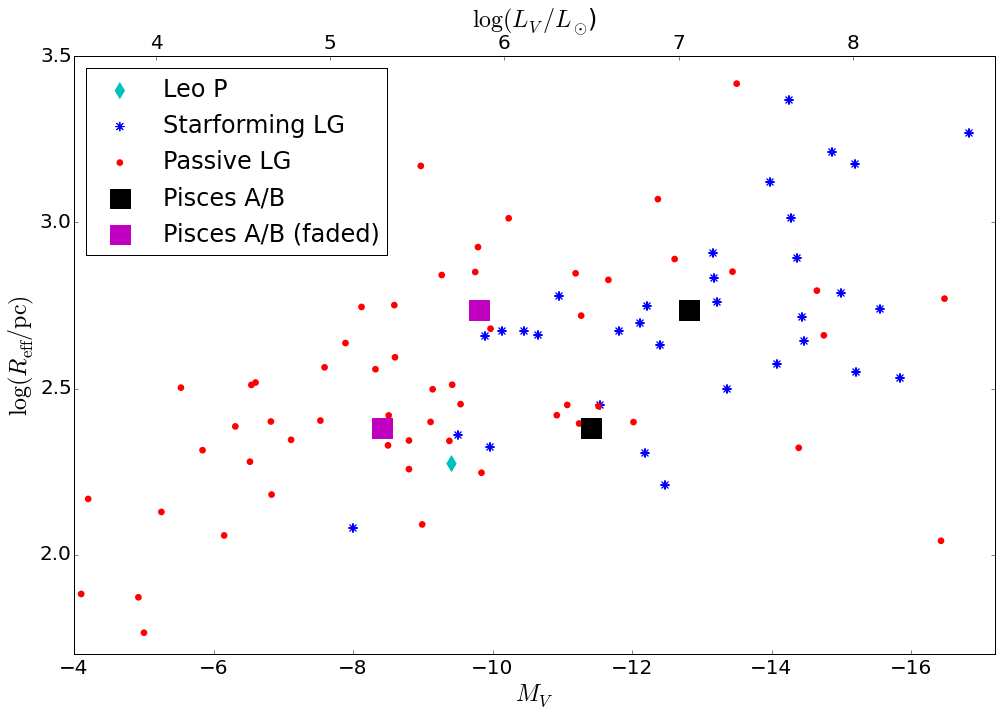

In [234]:
def make_mr_plot(leg=True, addleop=True, tcksfontsize=20, pointscale=1, piscdwarfs=True):
    msk = vabs <-0.5  # there are some failed points at ~0
    
    sfvabs = vabs[msk&sfing]
    sfRe = Reff.value[msk&sfing]

    if addleop:
        plt.scatter([leopMV.value], np.log10([leopRe/u.pc]), marker='d', c='c', label='Leo P',edgecolor='none',
                    s=100*pointscale, zorder=2)
        print([leopMV.value], np.log10([leopRe/u.pc]))
    plt.scatter(sfvabs, np.log10(sfRe)+3, lw=1, c='b', marker=(8, 2, 0), label='Starforming LG', s=50*pointscale)
    plt.scatter(vabs[msk&~sfing], np.log10(Reff.value[msk&~sfing])+3, edgecolor='none', c='r', label='Passive LG', s=30*pointscale)


    if piscdwarfs:
        plt.scatter(M606s, np.log10(Pisc_reffs/u.pc), s=250*pointscale, marker='s', color='k', label='Pisces A/B')
        plt.scatter(M606s+3*u.mag, np.log10(Pisc_reffs/u.pc), s=250*pointscale, marker='s', color='m', label='Pisces A/B (faded)')


    if leg:
        if leg is True:
            leg = 'upper left'
        plt.legend(loc=leg, scatterpoints=1, framealpha=1, fontsize=24)
    plt.ylim(1.7, 3.5)
    plt.ylabel(r'$\log(R_{\rm eff}/{\rm pc})$',fontsize=24)

    maglims = (-4,-17.2)
    plt.xlim(*maglims)
    plt.xlabel(r'$M_V$',fontsize=24)
    plt.xticks(fontsize=tcksfontsize)
    plt.yticks(fontsize=tcksfontsize)

    plt.twiny()
    plt.xlim((maglims[0]-4.83)/-2.5,(maglims[1]-4.83)/-2.5)
    plt.xlabel(r'$\log(L_V/L_\odot$)',fontsize=24)
    plt.xticks(fontsize=tcksfontsize)

plt.figure(figsize=(14,10))
make_mr_plot(pointscale=1.5, piscdwarfs=True)
plt.tight_layout()
#plt.savefig('/Users/erik/Documents/presentations/Chile15/context.pdf')

## Covariance plots

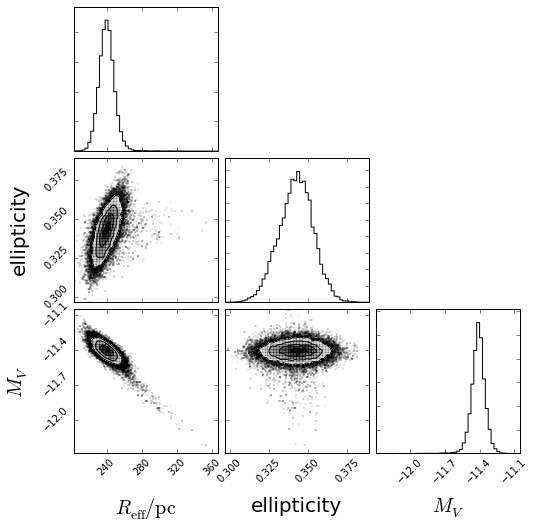

In [317]:
PiscA_chains = minify_chains(PiscA_dist,PiscA_reff.to(u.pc), get_struc_param('606A', 'ellipticity'), PiscA_M606)
chainslc = slice(1, None)
fig = corner(np.array(PiscA_chains[chainslc]).T, 
             labels=[r'Distance/Mpc', r'$R_{\rm eff}/{\rm pc}$', r'ellipticity', '$M_V$'][chainslc])
for ax in fig.axes:
    if ax.get_xlabel():
        ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    if ax.get_ylabel():
        ax.set_ylabel(ax.get_ylabel(), fontsize=20)
plt.savefig('/Users/erik/Documents/presentations/Chile15/PiscA_struc_covar.png')

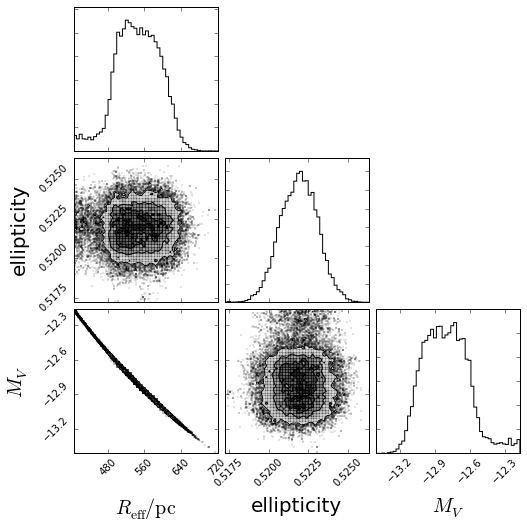

In [318]:
PiscB_chains = minify_chains(PiscB_dist,PiscB_reff.to(u.pc), get_struc_param('606B', 'ellipticity'), PiscB_M606)
chainslc = slice(1, None)
fig = corner(np.array(PiscB_chains[chainslc]).T, 
             labels=[r'Distance/Mpc', r'$R_{\rm eff}/{\rm pc}$', r'ellipticity', '$M_V$'][chainslc])
for ax in fig.axes:
    if ax.get_xlabel():
        ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    if ax.get_ylabel():
        ax.set_ylabel(ax.get_ylabel(), fontsize=20)
plt.savefig('/Users/erik/Documents/presentations/Chile15/PiscB_struc_covar.png')